In [ ]:
#import stuff
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
#import os
import cmocean
from cartopy.util import add_cyclic_point
from scipy import stats as stats

%matplotlib inline

In [4]:
#error in dp
def error_d(xa, ya): #error in double precision
    xa64 = xa.astype(np.float64)
    ya64 = ya.astype(np.float64)
    return xa64 - ya64

In [5]:
#calculate K-S p-value
def calc_ks(orig_val, recon_val):
    o64 = orig_val.astype(np.float64)
    r64 = recon_val.astype(np.float64)
    ks_stat, p_val = stats.ks_2samp(np.ravel(o64), np.ravel(r64))
    return p_val

In [6]:
orig_ds = xr.open_dataset('../data/orig.TS.100days.nc')

In [7]:
recon_ds = xr.open_dataset('../data/zfp1.0.TS.100days.nc')

In [8]:
recon_ds_2 = xr.open_dataset('../data/zfp1e-1.TS.100days.nc')

In [9]:
orig_ts = orig_ds['TS']

In [10]:
recon_ts = recon_ds['TS']

In [11]:
calc_ks(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.9999999999132105

In [12]:
#pearson correlation coefficient
def calc_corr(orig_val, recon_val):
    o64 = orig_val.astype(np.float64)
    r64 = recon_val.astype(np.float64)
    r, pval = stats.pearsonr(np.ravel(o64), np.ravel(r64))
    return r

In [13]:
calc_corr(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.9999947706571545

In [14]:
#normalized (by range) root mean square error
def calc_nrmse(orig_val, recon_val): 
    e = error_d(orig_val, recon_val)
    mse = np.sum(np.square(e)).mean()
    rmse = np.sqrt(mse)
    dy_range = np.max(orig_val)-np.min(orig_val)
    nrmse = rmse/dy_range
    #if you want to return a float
    return nrmse.data.item()


In [15]:
calc_nrmse(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.17907752867182808

In [16]:
#mean absolute error (not weighted - yet)
def calc_mae(orig_val, recon_val): 
    e = error_d(orig_val, recon_val)
    return (np.mean(np.abs(e))).data.item()


In [17]:
calc_mae(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.05852021166571864

In [18]:
#mean error
def calc_me(orig_val, recon_val): 
    e = error_d(orig_val, recon_val)
    return (np.mean(e)).data.item()

In [19]:
#max error
def calc_maxerr(orig_val, recon_val): 
    e = error_d(orig_val, recon_val)
    return (np.max(e)).data.item()

In [20]:
calc_me(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.00576729244656033

In [21]:
calc_maxerr(orig_ts.isel(time=0), recon_ts.isel(time=0))

0.4058837890625

In [22]:
#visualize mean value at each grid point for orig and compressed (time-series)
#assuming FV data and put the weighted mean
def plot_compare_mean(orig_ds, recon_ds, varname):
    var_orig_ds = orig_ds[varname]
    var_recon_ds = recon_ds[varname]
    mean_data_o = var_orig_ds.mean(dim='time')
    mean_data_r = var_recon_ds.mean(dim='time')

    #weighted mean
    gw_o = orig_ds['gw'].values
    gw_r = recon_ds['gw'].values
    o_wt_mean = np.average(np.average(mean_data_o,axis=0, weights=gw_o))
    r_wt_mean = np.average(np.average(mean_data_r,axis=0, weights=gw_r))

    lat_o = orig_ds['lat']
    lat_r = recon_ds['lat']
    cy_data_o, lon_o = add_cyclic_point(mean_data_o, coord=orig_ds['lon'])
    cy_data_r, lon_r = add_cyclic_point(mean_data_r, coord=recon_ds['lon'])
    fig = plt.figure(dpi=300)
    
    mymap = cmocean.cm.thermal
    nlevs = 24
    
    ax1 = plt.subplot(2, 1, 1, projection=ccrs.Robinson(central_longitude=0.0))
    title = f'orig:{varname} : mean = {o_wt_mean:.2f}'
    ax1.set_title(title)
    pc1 = ax1.contourf(lon_o, lat_o, cy_data_o, transform=ccrs.PlateCarree(), cmap=mymap, levels=nlevs)
    cb1 = plt.colorbar(pc1, orientation='vertical', shrink=0.95)
    ax1.set_global()
    ax1.coastlines()

    ax2 = plt.subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=0.0))
    title = f'comp:{varname} : mean = {r_wt_mean:.2f}'
    ax2.set_title(title)
    pc2 = ax2.contourf(lon_r, lat_r, cy_data_r, transform=ccrs.PlateCarree(), cmap=mymap, levels=nlevs)
    cb2 = plt.colorbar(pc2, orientation='vertical', shrink=0.95)
    ax2.set_global()
    ax2.coastlines()

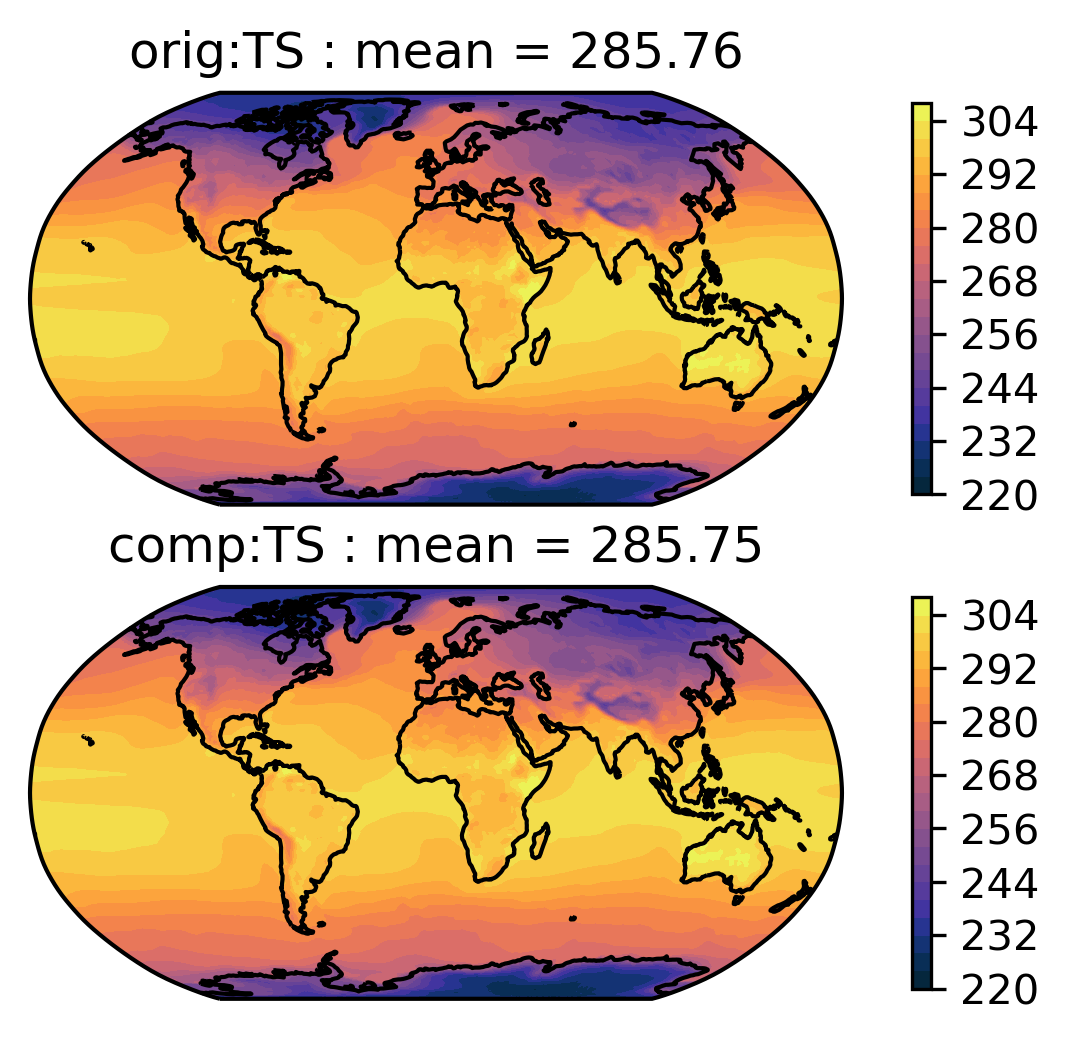

In [27]:
plot_compare_mean(orig_ds, recon_ds, 'TS')

In [24]:
#TO DO:visualize std devat each grid point for orig and compressed (time-series)
#assuming FV mean

In [ ]:
#visualize the mean error
#want to be able to input multiple?
def plot_mean_error(orig_ds, recon_ds, varname):
    var_orig_ds = orig_ds[varname]
    var_recon_ds = recon_ds[varname]
    e = var_orig_ds - var_recon_ds
    mean_e = e.mean(dim='time')
    lat = orig_ds['lat']
    cy_data, lon = add_cyclic_point(mean_e, coord=orig_ds['lon'])
    fig = plt.figure(dpi=300)
    mymap = cmocean.cm.thermal
    nlevs = 24
    ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=0.0))
    #pc = ax.pcolormesh(lon, lat, cy_data, transform=ccrs.PlateCarree(), cmap=mymap)
    pc = ax.contourf(lon, lat, cy_data, transform=ccrs.PlateCarree(), cmap=mymap, levels=nlevs)
    cb = plt.colorbar(pc, orientation='vertical', shrink=0.95)
    ax.set_global()
    ax.coastlines()
    #title = f'orig:{varname} : mean error'
    #ax.set_title(title)

    

In [ ]:
plot_mean_error(orig_ds, recon_ds, 'TS')